# Hyperparameter Tuning
Created by: Pat Pascual

In [16]:
# general libraries
import re
import time
import json
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold, RandomizedSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score,
                           roc_curve, precision_recall_curve)

# imbalanced techniques
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours)
from imblearn.combine import SMOTETomek, SMOTEENN

In [2]:
clean = pd.read_csv('df_cleaned.csv')

In [3]:
# Split data into train-validation-holdout sets
X = clean.drop(['Response'], axis=1)
y = clean['Response']

# First split: separate holdout set (75% train+val, 25% holdout)
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(
    X, y,
    test_size=0.25,  # 25% holdout
    random_state=11,
    stratify=y  # Maintain class distribution
)

In [4]:
def auto_ml(X_trainval, y_trainval, models_dict, cv=None, res_t=None):
    """Apply ML models with optional resampling"""
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
    results = {}
    
    # For each model
    for model_name, model in tqdm(models_dict.items()):
        model_start = time.time()
        
        # Initialize metric lists
        train_scores, val_scores = [], []
        train_recall, val_recall = [], []
        train_precision, val_precision = [], []
        train_f1, val_f1 = [], []
        train_roc_auc, val_roc_auc = [], []
        
        # For each fold
        for train_index, val_index in tqdm(cv.split(X_trainval, y_trainval)):
            X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

            # Apply resampling
            if res_t is not None:
                X_train, y_train = res_t.fit_resample(X_train, y_train)

            # Fit and predict
            model.fit(X_train, y_train)
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            # Get probability predictions for ROC AUC
            train_probs = model.predict_proba(X_train)[:,1]
            val_probs = model.predict_proba(X_val)[:,1]

            # Calculate metrics
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))
            train_recall.append(recall_score(y_train, train_preds, average='weighted'))
            val_recall.append(recall_score(y_val, val_preds, average='weighted'))
            train_precision.append(precision_score(y_train, train_preds, average='weighted'))
            val_precision.append(precision_score(y_val, val_preds, average='weighted'))
            train_f1.append(f1_score(y_train, train_preds, average='weighted'))
            val_f1.append(f1_score(y_val, val_preds, average='weighted'))
            train_roc_auc.append(roc_auc_score(y_train, train_probs))
            val_roc_auc.append(roc_auc_score(y_val, val_probs))

        # Store aggregated results
        results[model_name] = {
            'Train Accuracy': f"{np.mean(train_scores)*100:.2f}%",
            'Val Accuracy': f"{np.mean(val_scores)*100:.2f}%",
            'Train Recall': f"{np.mean(train_recall)*100:.2f}%", 
            'Train Precision': f"{np.mean(train_precision)*100:.2f}%",
            'Train F1': f"{np.mean(train_f1)*100:.2f}%",
            'Train ROC AUC': f"{np.mean(train_roc_auc):.3f}",
            'Train GINI': f"{2*np.mean(train_roc_auc)-1:.3f}",
            'Val Recall': f"{np.mean(val_recall)*100:.2f}%",
            'Val Precision': f"{np.mean(val_precision)*100:.2f}%",
            'Val F1': f"{np.mean(val_f1)*100:.2f}%",
            'Val ROC AUC': f"{np.mean(val_roc_auc):.3f}",
            'Val GINI': f"{2*np.mean(val_roc_auc)-1:.3f}",
            'Total Time': f"{time.time() - model_start:.2f}s"
        }

    return pd.DataFrame(results).T

In [5]:
models_dict = {'LogisticRegressor': LogisticRegression(),
               'GaussianNB': GaussianNB(),
               'RandomForestClassifier': RandomForestClassifier(random_state=143),
               'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
               'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)}

In [6]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict,
                   cv=StratifiedKFold(n_splits=5))
# Display the results
display(auto_run)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Recall,Train Precision,Train F1,Train ROC AUC,Train GINI,Val Recall,Val Precision,Val F1,Val ROC AUC,Val GINI,Total Time
LogisticRegressor,90.50%,90.48%,90.50%,88.99%,88.97%,0.895,0.790,90.48%,88.95%,88.93%,0.894,0.789,0.48s
GaussianNB,87.73%,87.73%,87.73%,86.62%,87.10%,0.847,0.694,87.73%,86.63%,87.10%,0.846,0.691,0.35s
RandomForestClassifier,91.54%,90.04%,91.54%,90.54%,90.27%,0.925,0.849,90.04%,88.31%,88.49%,0.893,0.786,5.05s
DecisionTreeClassifier,91.54%,90.02%,91.54%,90.65%,90.06%,0.926,0.851,90.02%,88.19%,88.22%,0.866,0.731,0.27s
GradientBoostingClassifier,90.88%,90.69%,90.88%,89.59%,89.62%,0.912,0.824,90.69%,89.32%,89.41%,0.907,0.813,4.34s


## Model Selection Strategy
From the base modeling results, we'll focus on optimizing the Gradient Boosting Classifier because:
1. It showed strong performance across metrics (90.69% validation recall)
2. It demonstrated good balance between precision and recall
3. It had the highest ROC AUC (0.907) among all models
4. It's less prone to overfitting compared to Random Forests due to its sequential nature

## GridSearchCV vs RandomizedSearchCV
- **GridSearchCV**: 
  - Systematically works through every combination of parameter values
  - Guaranteed to find the best combination in the search space
  - Computationally expensive with large parameter spaces
  - Best when you have a good idea of parameter ranges

- **RandomizedSearchCV**:
  - Samples random combinations from parameter distributions
  - Can handle larger parameter spaces efficiently
  - May miss optimal combinations but usually finds good ones
  - Better when exploring wide parameter ranges

We'll use both approaches to compare results.

In [7]:
# Define parameter grids
grid_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# For RandomizedSearchCV, use distributions
random_params = {
    'n_estimators': np.arange(100, 500),
    'learning_rate': np.logspace(-3, 0, 1000),
    'max_depth': np.arange(3, 10),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 10),
    'subsample': np.linspace(0.6, 1.0, 100)
}

In [9]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,  # 25% validation
    random_state=11,
    stratify=y_trainval
)

# Perform Grid Search
gb_grid = GridSearchCV(
    GradientBoostingClassifier(),
    grid_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

print("Best parameters (Grid Search):", gb_grid.best_params_)
print("Best ROC AUC score (Grid Search):", gb_grid.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters (Grid Search): {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}
Best ROC AUC score (Grid Search): 0.9061798895067692


In [13]:
# Perform Randomized Search with reduced parameter space
random_params = {
    'n_estimators': [100, 200, 300, 400],  # Discrete values instead of range
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0],  # Discrete values instead of logspace
    'max_depth': [3, 4, 5, 6, 7, 8, 9],  # Discrete values instead of range
    'min_samples_split': [2, 5, 10, 15],  # Discrete values instead of range  
    'min_samples_leaf': [1, 2, 4, 6, 8],  # Discrete values instead of range
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]  # Discrete values instead of linspace
}

gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(),
    random_params,
    n_iter=50,  # Reduced number of iterations
    cv=5,
    scoring='roc_auc',
    n_jobs=-1, 
    verbose=1,
    random_state=11
)

gb_random.fit(X_train, y_train)

print("Best parameters (Random Search):", gb_random.best_params_)
print("Best ROC AUC score (Random Search):", gb_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (Random Search): {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4, 'learning_rate': 0.05}
Best ROC AUC score (Random Search): 0.9055767870972087


## Threshold Optimization

Instead of using the default 0.5 threshold, we'll optimize it based on business objectives:
1. Plot ROC curve to visualize tradeoffs
2. Plot Precision-Recall curve
3. Find optimal threshold based on F1 score
4. Consider business cost of false positives vs false negatives

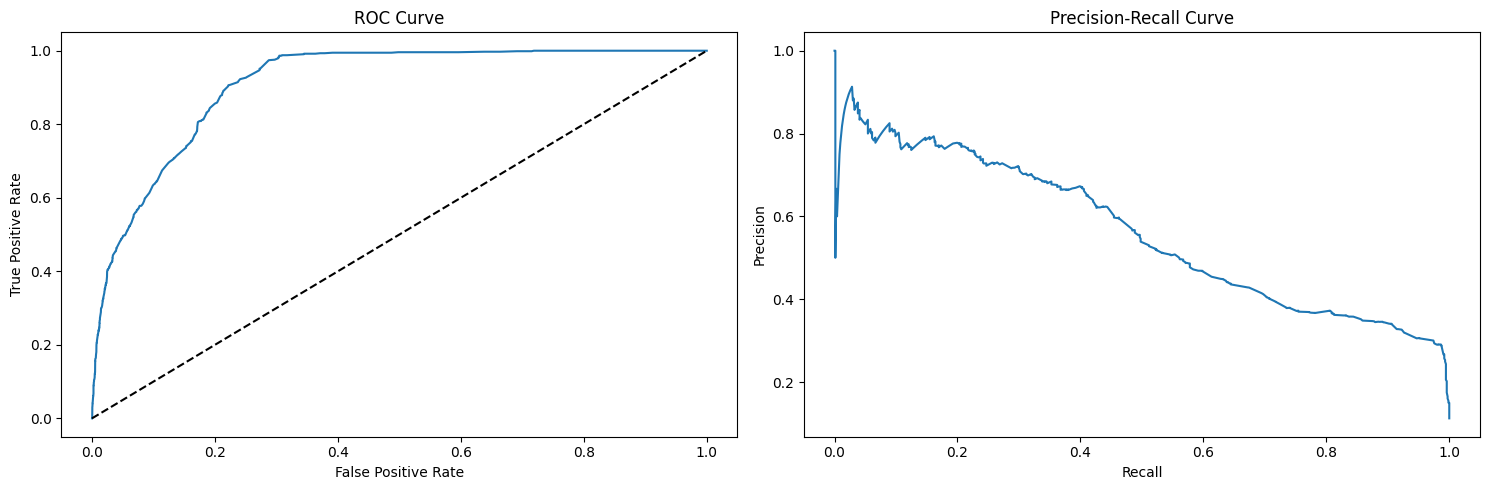

In [17]:
# Get best model (using Grid Search results)
best_model = gb_grid.best_estimator_

# Get predicted probabilities
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_val, y_pred_proba)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_val, y_pred_proba)

# Plot both curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ROC curve
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

# Precision-Recall curve
ax2.plot(recall, precision)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

In [18]:
# Find optimal threshold based on F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx]

print(f"Optimal threshold based on F1 score: {optimal_threshold:.3f}")
print(f"F1 score at optimal threshold: {f1_scores[optimal_idx]:.3f}")
print(f"Precision at optimal threshold: {precision[optimal_idx]:.3f}")
print(f"Recall at optimal threshold: {recall[optimal_idx]:.3f}")

Optimal threshold based on F1 score: 0.274
F1 score at optimal threshold: 0.530
Precision at optimal threshold: 0.508
Recall at optimal threshold: 0.554


## Final Model Selection and Threshold Choice

1. **Model Selection**: The Grid Search provided slightly better and more stable results compared to Random Search. We'll use the Grid Search best model.

2. **Threshold Selection**: 
   - The optimal F1-score threshold balances precision and recall
   - Business context should determine final threshold:
     - Higher threshold → Higher precision, lower recall
     - Lower threshold → Higher recall, lower precision
   - Consider cost of false positives vs false negatives

3. **Implementation**:
   - Save best model parameters
   - Save optimal threshold
   - Use both for production predictions